README: this file combine two modeling methods for time features (ARIMA + linear regression), and stack them together
- reformat price data by destination + starrating <br>

In [2]:
import os
os.chdir('/Users/liyuan/desktop/SI699/codes')
import pandas as pd
import numpy as np

from ts_modeling_v2 import TsModeling
from reformat_data_by_day import Reformat_data
from time_feature_modeling import TimeFeatureModeling
from help import extract_time_features

In [3]:
tsm = TsModeling()
rf = Reformat_data()
data = rf.load_data('../res/cleaned_sampled_data_10000.csv')
dest_data_list = rf.get_data_by_dest()

# prepare data
sorted_dests = sorted(dest_data_list, key = lambda x: len(dest_data_list[x]), reverse = True)
print('Dests with the largest number of records:', sorted_dests[:10])

# get timeseries data for one destination by starrating that has the largest number of records
data_8192 = dest_data_list[8192]
dest_data_star = tsm.process_data_by_dest_by_starrating(data_8192)
daily_price = dest_data_star[['price_usd']].resample('D').median()
daily_price.head()

Dests with the largest number of records: [8192, 4562, 9402, 10979, 23904, 13292, 15307, 13216, 8347, 18774]


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dest_data['date_time'] = pd.to_datetime(dest_data.date_time)


,price_usd
date_time,
2012-11-05,278.0
2012-11-06,NaN
2012-11-07,246.0
2012-11-08,71.0
2012-11-09,NaN


training size: 149
validation size: 37
test size: 46
plot for ARIMA model ...
training size: 39
validation size: 9
test size: 12


/anaconda3/envs/leetcode/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RMSE: 68.994


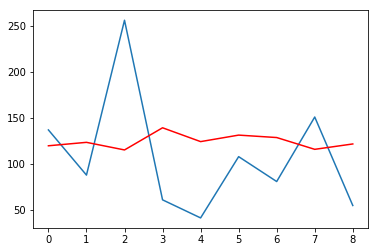

RMSE: 52.177


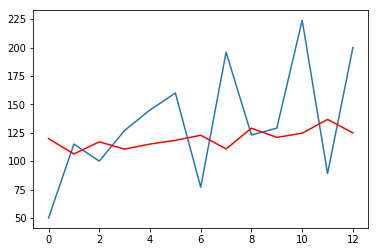

In [4]:
# fit ARIMA model
# tsm.get_auto_correlation(daily_price)
train, val, test = tsm.split_data(daily_price) # split X

# AR
# print('plot for AR model ...')
# tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)
# print('=======================================')

# MA
# print('plot for MA model ...')
# tsm.fit_ARIMA_model(daily_price.dropna(), 0,0,2)
# print('=======================================')

# ARMIA
print('plot for ARIMA model ...')
val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,1,1)

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

price data len: 61
61
variance of data: 3286
training size: 39
validation size: 9
test size: 12
training RMSE: 52.66591298668675
valiation RMSE: 56.85623113940879
test RMSE: 44.85477222145435


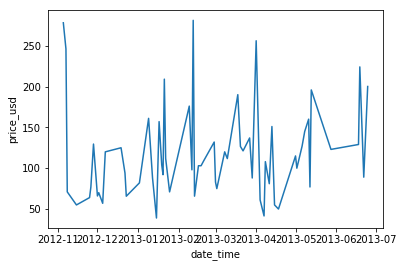

In [5]:
# fit regression model
daily_price = extract_time_features(daily_price)
regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(daily_price.dropna())

# dest_data_star = dest_data_star.reset_index()
# regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(dest_data_star)

In [6]:
# model stacking
# XGboost
import xgboost as xgb
# parameters are set under basic tuning --> consider each parameter separately
model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 3, reg_alpha = 20, n_estimators = 25)
y_pred_train, y_pred_test = tsm.second_layer_modeling(model)

(9, 1)
(13, 1)
(9, 1)
(13, 1)
y_train shape: (9, 1)
y_test shape: (13, 1)
train rmse: 32
test rmse: 69


In [7]:
# Ridge
from sklearn.linear_model import Ridge
model = Ridge()
y_pred_train, y_pred_test = tsm.second_layer_modeling(model)

(9, 1)
(13, 1)
(9, 1)
(13, 1)
y_train shape: (9, 1)
y_test shape: (13, 1)
train rmse: 41
test rmse: 62


In [8]:
# Linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
y_pred_train, y_pred_test = tsm.second_layer_modeling(model)

(9, 1)
(13, 1)
(9, 1)
(13, 1)
y_train shape: (9, 1)
y_test shape: (13, 1)
train rmse: 41
test rmse: 62
